<a href="https://www.kaggle.com/code/samithsachidanandan/lstm-time-series-forecasting-tensorflow-python?scriptVersionId=297463379" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Import Libraries 

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

import yfinance as yf
from datetime import date, timedelta, datetime
from tensorflow import keras 
from sklearn.preprocessing import StandardScaler
import seaborn as sns 
import os 

os.environ["TF_CPP_MIN_LOG_LEVEL"] = '2'

import warnings
warnings.filterwarnings("ignore")

2026-02-13 06:57:21.456244: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770965841.677629      17 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770965841.743327      17 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770965842.302777      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770965842.302835      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770965842.302838      17 computation_placer.cc:177] computation placer alr

In [2]:
# Time period for the data
end_date = date.today().strftime("%Y-%m-%d")
start_date = (date.today() - timedelta(days=1826)).strftime("%Y-%m-%d")

# Data import 

In [3]:
data = yf.download('MSFT', start=start_date, end=end_date, progress=False)

data.columns = ['_'.join(col).strip() for col in data.columns.values]

data = data.reset_index()

data_melted = data.melt(
    id_vars=['Date'],
    var_name='Attribute_Ticker',
    value_name='Value'
)


data_melted[['Attribute', 'Name']] = (
    data_melted['Attribute_Ticker']
    .str.rsplit('_', n=1, expand=True)
)


data_pivoted = data_melted.pivot_table(
    index=['Date', 'Name'],
    columns='Attribute',
    values='Value',
    aggfunc='first'
).reset_index()


data_pivoted.columns = [col.lower() for col in data_pivoted.columns]


data_pivoted = data_pivoted[
    ['date', 'open', 'high', 'low', 'close', 'volume', 'name']
]

stock_data = data_pivoted


In [4]:
stock_data.head()

,date,open,high,low,close,volume,name
0,2021-02-16,235.116064,236.171564,233.091434,233.839874,26728500.0,MSFT
1,2021-02-17,232.089454,234.965077,231.723985,234.859283,21653500.0,MSFT
2,2021-02-18,232.551078,234.599595,231.647031,234.464951,16925600.0,MSFT
3,2021-02-19,234.426517,234.532310,230.993063,231.752853,25262600.0,MSFT
4,2021-02-22,228.338643,228.829130,223.510655,225.539948,36446900.0,MSFT


# Basics stats

In [5]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1255 entries, 0 to 1254
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1255 non-null   datetime64[ns]
 1   open    1255 non-null   float64       
 2   high    1255 non-null   float64       
 3   low     1255 non-null   float64       
 4   close   1255 non-null   float64       
 5   volume  1255 non-null   float64       
 6   name    1255 non-null   object        
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 68.8+ KB


In [6]:
stock_data.describe()

,date,open,high,low,close,volume
count,1255,1255.000000,1255.000000,1255.000000,1255.000000,1.255000e+03
mean,2023-08-13 12:45:19.362549760,347.965871,351.131134,344.578367,347.985943,2.573286e+07
min,2021-02-16 00:00:00,211.872987,214.658329,207.860489,208.659073,5.855900e+06
25%,2022-05-12 12:00:00,270.010921,273.651966,267.376082,270.303986,1.892270e+07
50%,2023-08-14 00:00:00,327.217203,329.842485,323.962404,326.873016,2.324530e+07
75%,2024-11-09 12:00:00,417.746045,420.973181,413.405699,416.943558,2.953260e+07
max,2026-02-12 00:00:00,553.283183,553.502444,539.759814,541.057373,1.288553e+08
std,NaN,88.938625,89.190518,88.391139,88.786922,1.062695e+07


# EDA

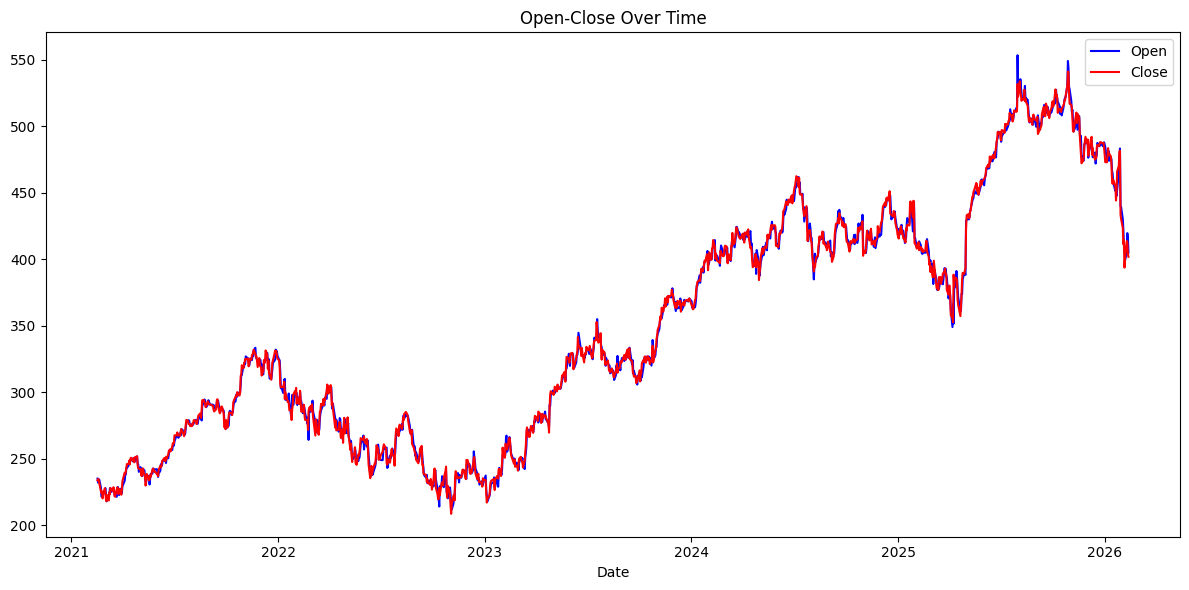

In [7]:
plt.figure(figsize=(12,6))
plt.plot(stock_data['date'], stock_data['open'], label='Open', color='blue')
plt.plot(stock_data['date'], stock_data['close'], label='Close', color='red')
plt.xlabel('Date')
plt.title('Open-Close Over Time')
plt.legend()
plt.tight_layout()
plt.show()

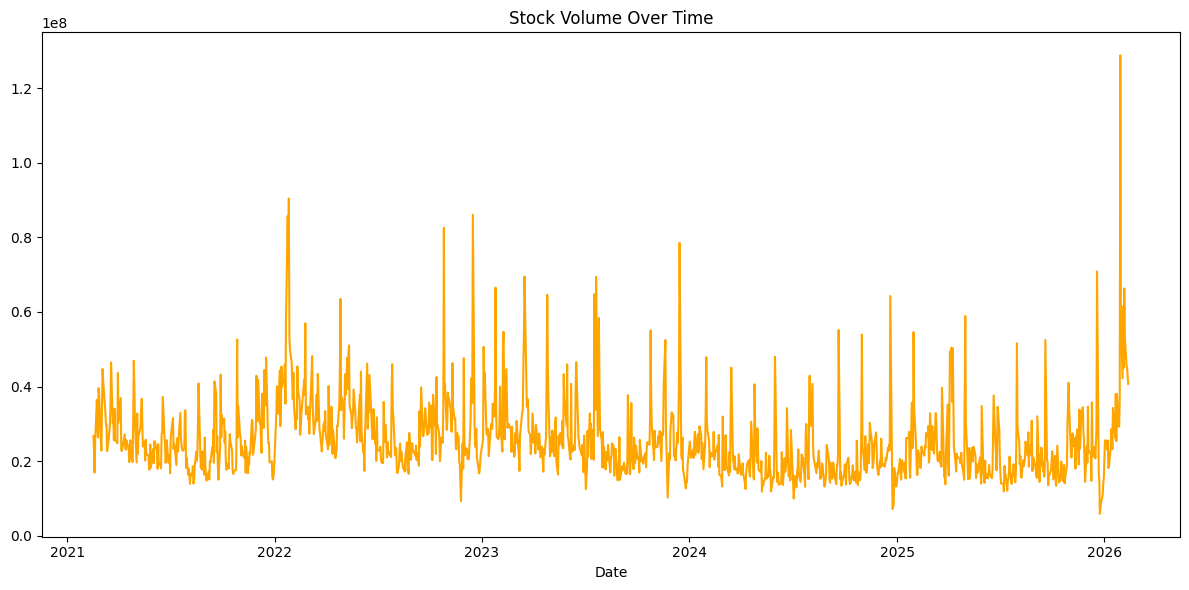

In [8]:
plt.figure(figsize=(12,6))
plt.plot(stock_data['date'], stock_data['volume'], label='Volume', color='orange')
plt.xlabel('Date')
plt.title('Stock Volume Over Time')
plt.tight_layout()
plt.show()

In [9]:
numeric_data = stock_data.select_dtypes(include=["int64", "float64"])

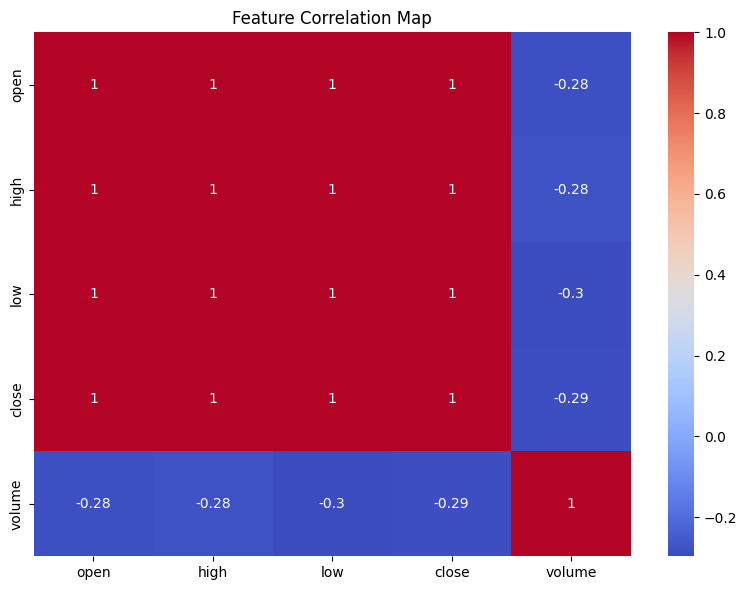

In [10]:
plt.figure(figsize=(8,6))
sns.heatmap(numeric_data.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Map")
plt.tight_layout()
plt.show()

# Data Converstion 

In [11]:
stock_data['date'] = pd.to_datetime(stock_data['date'])

In [12]:
prediction = data.loc[
    (stock_data['date'] > datetime(2021,1,1)) & 
    (stock_data['date'] < datetime(2026,1,1))
]


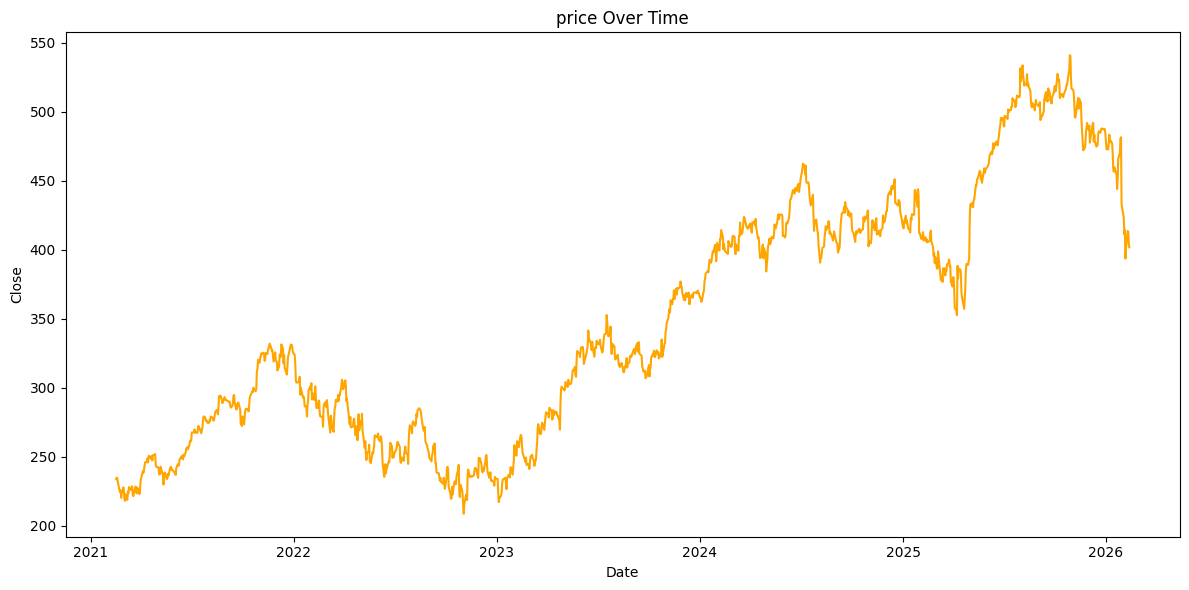

In [13]:
plt.figure(figsize=(12,6))
plt.plot(stock_data['date'], stock_data['close'], color='orange')
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('price Over Time')
plt.tight_layout()
plt.show()

# LSTM Model 

In [14]:
stock_close = stock_data["close"]

# Converting to numpy array 
dataset = stock_close.values

training_data_len = int(np.ceil(len(dataset) * 0.95))

dataset = dataset.reshape(-1, 1)


# Preprocessing 

In [15]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(dataset)

training_data = scaled_data[:training_data_len]

In [16]:

X_train, y_train = [], []

for i in range(60, len(training_data)):
    X_train.append(training_data[i-60: i,0])
    y_train.append(training_data[i,0])


X_train, y_train = np.array(X_train),np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))

model = keras.models.Sequential([
    keras.layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    keras.layers.LSTM(64, return_sequences=False),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1)
])

model.summary()

2026-02-13 06:57:41.197163: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,369 (228.00 KB)

 Trainable params: 58,369 (228.00 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
model.compile(optimizer="adam",loss ="mae",metrics=[keras.metrics.RootMeanSquaredError()])

training = model.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.4842 - root_mean_squared_error: 0.6122
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.1782 - root_mean_squared_error: 0.2314
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.1609 - root_mean_squared_error: 0.2166
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.1444 - root_mean_squared_error: 0.1885
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.1418 - root_mean_squared_error: 0.1966
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.1327 - root_mean_squared_error: 0.1752
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.1389 - root_mean_squared_error: 0.1839
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.1289 - root_mean_squared_error: 0.1714
Epoch 9/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.1210 - root_mean_squared_error: 0.1575
Epoch 10/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.1284 - root_mean_squared_error: 0.1714

In [18]:
test_data = scaled_data[training_data_len - 60: ]
X_test, y_test = [], dataset[training_data_len:]

In [19]:
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i,0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))

In [20]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


In [21]:
train = stock_data[:training_data_len]
test = stock_data[training_data_len:]

test = test.copy()

test['Predictions'] =  predictions

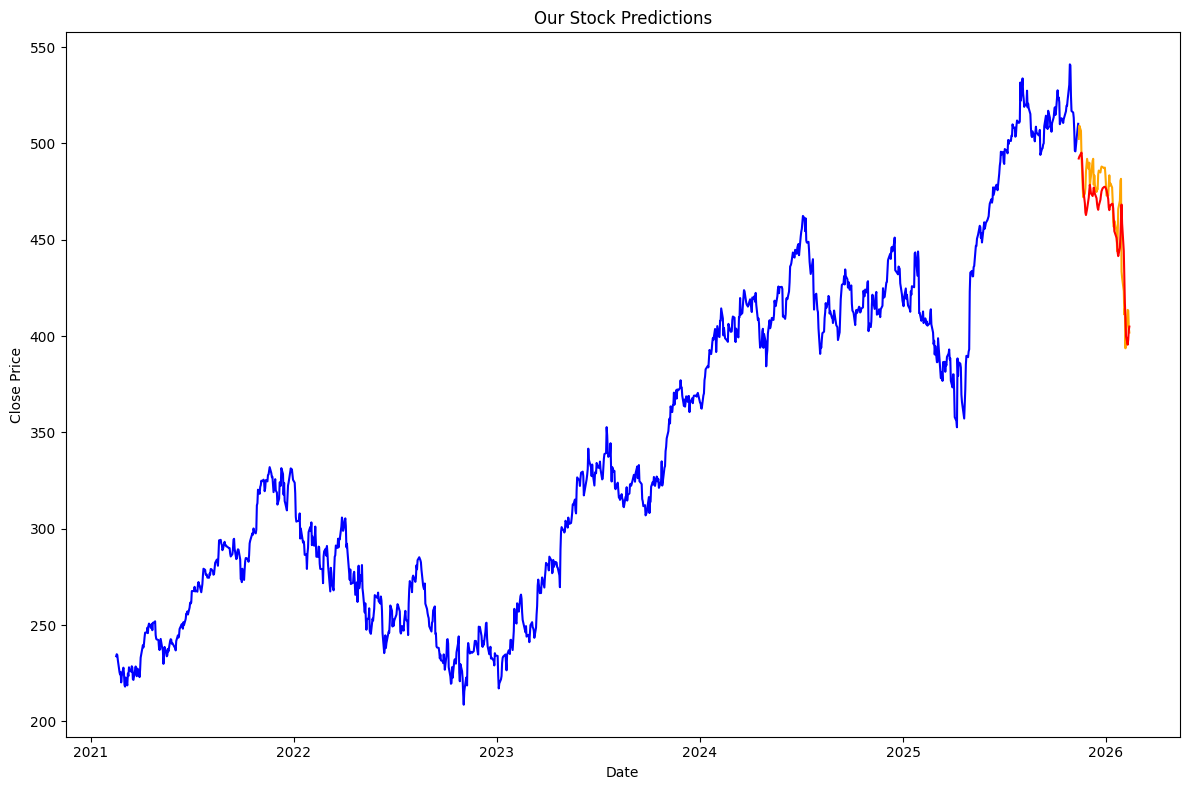

In [22]:
plt.figure(figsize=(12,8))
plt.plot(train['date'], train['close'], label="Train (Actual)", color="blue")
plt.plot(test['date'], test['close'], label="Test (Actual)", color="orange")
plt.plot(test['date'], test['Predictions'], label="Predictions", color="red")
plt.title('Our Stock Predictions')
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.tight_layout()
plt.show()